# Forecasting Retail Sales using Time Series Models.


DESCRIPTION:
The objective of this project is to develop a robust time series forecasting model that can accurately predict the unit sales for various items sold in Favorita stores. Favorita is a leading grocery retailer based in Ecuador, and the company's sales data will be used to build the model. The data set contains sales data for thousands of items sold at different stores, making it a challenging and complex problem.

To build an accurate forecasting model, various statistical and machine learning techniques will be used. The data will be preprocessed to ensure that it is clean, consistent, and in the right format for analysis. Exploratory data analysis (EDA) techniques will be employed to gain a deeper understanding of the data and identify any patterns or trends in the sales data.

Time series forecasting models, such as ARIMA, Linear regression and a few others will be used to predict store sales. These models will be trained using historical sales data, and their accuracy will be evaluated using various performance metrics such as root mean square logarithmic error, root mean squared error (RMSE), and mean square error (MSE).

The results obtained from the forecasting models will be analyzed, and insights gained from the analysis will be used to make informed business decisions. The insights could include identifying which products have high demand at different times of the year, which stores perform better than others, and identifying any trends in sales data that could inform marketing and inventory decisions.

Overall, the project aims to build a reliable time series forecasting model that can help Favorita optimize their sales strategies and improve their bottom line.

## Hypothesis

##### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

#####  ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2 

##### ALTENATE Hypothesis: There is a significant difference in sales before and after promotion 

##### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

##### ALTERNATE Hypothesis: The average sales of product family X differ between store Y1 and store Y2. 

## Questions

Is the train dataset complete (has all the required dates)?

Which dates have the lowest and highest sales for each year?

Did the earthquake impact sales?

Are certain groups of stores selling more products? (Cluster, city, state, type)

Are sales affected by promotions, oil prices and holidays?

What analysis can we get from the date and its extractable features?

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


### Data Importation
The project starts by importing necessary libraries and environment variables from the '.env' file. It then establishes a connection to the SQL Server using the provided credentials and loads data from three tables: 'dbo.oil', 'dbo.holidays_events', and 'dbo.stores'. Additionally, data from two local CSV files, 'sample_submission.csv' and 'test.csv', is imported using pandas. Lastly, data from a zip file, 'train.csv' and 'transactions.csv', is loaded into the DataFrame 'df_train' and 'df_transactions', respectively.

In [1]:
### Data importation
#pip install pyodbc
#pip install sqlalchemy
#pip install lightgbm
#pip install catboost
#pip install python-dotenv
#pip install pmdarima



In [2]:
# Libraries Importation
import pyodbc
import sqlalchemy as sa
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from dotenv import dotenv_values
from scipy import stats
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from pmdarima.arima import auto_arima
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [4]:
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("username")
password = environment_variables.get("password")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

conn = pyodbc.connect(connection_string)

In [5]:
#define the tables
table1 = 'dbo.oil'
table2 = 'dbo.holidays_events'
table3 = 'dbo.stores'

In [6]:
#creating  query to select the tables to be imported
query1 = f"SELECT * FROM {table1}"
df_oil = pd.read_sql(query1, conn)

query2 = f"SELECT * FROM {table2}"
df_holidays_events = pd.read_sql(query2, conn)

query3 = f"SELECT * FROM {table3}"
df_stores= pd.read_sql(query3, conn)

In [7]:
#close the connection
conn.close()

In [8]:
#importing local csv data
df_sample_submission=pd.read_csv('../Regression_Time_Series/Assets/sample_submission.csv')
df_test=pd.read_csv('../Regression_Time_Series/Assets/test.csv')

with zipfile.ZipFile('../Regression_Time_Series/Assets/trai&transactions.zip', 'r') as zip_ref:
    # Read the contents of the zip file
    with zip_ref.open('train.csv') as file_train:
        df_train = pd.read_csv(file_train)

    with zip_ref.open('transactions.csv') as file_transactions:
        df_transactions = pd.read_csv(file_transactions)


### Data Preparation

#### Oil Prices
The 'df_oil' DataFrame contains daily oil price data.
(Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
The following data preparation steps are performed:

-Check for missing values, resulting in finding one missing value in the 'dcoilwtico' column.

-Fill the missing value using the forward-fill method to propagate the last valid observation forward.

-Convert the 'date' column to datetime format.
Extracted additional date features like 'year', 'month', 'day', and 'day_of_week'.

-Checked for duplicate rows and found none, so no duplicate rows were dropped.

-Checked for zero or negative oil prices and found none. No rows were removed or replaced.


In [9]:
df_oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [10]:
# Check for missing values in df_oil
df_oil.isnull().sum()


date           0
dcoilwtico    43
dtype: int64

In [11]:
# Fill missing values using forward-fill method
df_oil.fillna(method='ffill', inplace=True)

# Verify if there are any missing values after filling
df_oil.isnull().sum()


date          0
dcoilwtico    1
dtype: int64

In [12]:

# Drop rows with missing values in 'dcoilwtico' column
df_oil.dropna(subset=['dcoilwtico'], inplace=True)

# Verify if there are any missing values after filling
df_oil.isnull().sum()



date          0
dcoilwtico    0
dtype: int64

In [13]:
# Convert 'date' column to datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'])


In [14]:
# Extract additional date features
df_oil['year'] = df_oil['date'].dt.year
df_oil['month'] = df_oil['date'].dt.month
df_oil['day'] = df_oil['date'].dt.day
df_oil['day_of_week'] = df_oil['date'].dt.dayofweek


In [15]:
# Check data types of columns in df_oil
df_oil.dtypes


date           datetime64[ns]
dcoilwtico            float64
year                    int64
month                   int64
day                     int64
day_of_week             int64
dtype: object

In [16]:
# Check for duplicate rows in df_oil
duplicate_rows = df_oil[df_oil.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_oil.drop_duplicates(inplace=True)


Number of duplicate rows: 0


In [17]:
# Check for zero or negative oil prices
invalid_prices = df_oil[df_oil['dcoilwtico'] <= 0]
print("Number of rows with zero or negative oil prices:", invalid_prices.shape[0])

# Replace or remove rows with zero or negative oil prices 

mean_oil_price = df_oil[df_oil['dcoilwtico'] > 0]['dcoilwtico'].mean()
df_oil.loc[df_oil['dcoilwtico'] <= 0, 'dcoilwtico'] = mean_oil_price


Number of rows with zero or negative oil prices: 0


In [18]:
# checking for seasonal decomposition using statsmodels library

# 'date' is set as the index of df_oil
result = seasonal_decompose(df_oil['dcoilwtico'], model='additive', period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid



#### Holiday Events
The 'df_holidays_events' DataFrame contains holidays and events data

Check for missing values.
Convert the 'date' column to datetime format.
Extract additional date features like 'year', 'month', 'day', and 'day_of_week'.
Check for duplicate rows.
Handle any necessary cleaning or adjustments specific to this DataFrame.

In [19]:
df_holidays_events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [20]:
# Check for missing values in df_holidays_events
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [21]:
# Convert 'date' column to datetime format
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

In [22]:
# Extract additional date features
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

In [23]:
# Check for duplicate rows in df_holidays_events
duplicate_rows = df_holidays_events[df_holidays_events.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])


Number of duplicate rows: 0


In [24]:
# Filter holidays with 'type' as 'Transfer'
transfer_holidays = df_holidays_events[df_holidays_events['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
transfer_holidays


,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,4
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2013,10,11,4
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2014,10,10,4
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False,2016,5,27,4
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,2016,7,24,6
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,2016,8,12,4
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False,2017,1,2,0
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False,2017,4,13,3
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False,2017,5,26,4
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,2017,8,11,4


The code below defines a function 'handle_transferred_holidays' to adjust the holiday dates for transferred holidays. It checks if a holiday is transferred (True), then finds the corresponding row where the 'type' is 'Transfer' and the 'description' matches, and retrieves the transfer date. The adjusted date is then updated in the 'date' column. The 'transferred' column is dropped as it is no longer needed.

In [25]:
# Function to handle transferred holidays
def handle_transferred_holidays(row):
    if row['type'] == 'Transfer':
        corresponding_row = df_holidays_events[(df_holidays_events['description'] == row['description']) & 
                                               (df_holidays_events['type'] != 'Transfer') & 
                                               (df_holidays_events['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to update the date for transferred holidays
df_holidays_events['date'] = df_holidays_events.apply(handle_transferred_holidays, axis=1)

# Update the additional date features after handling transferred holidays
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

# Drop any duplicate rows created after handling transferred holidays
df_holidays_events.drop_duplicates(inplace=True)


df_holidays_events.head()


,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,4
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1,6
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,3
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,5
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,5


#### Stores

For data preparation on the df_stores DataFrame, we need to ensure that the data is cleaned, consistent, and in the right format for further analysis. 
Steps:
We will first check if there are any missing values in the DataFrame.
Ensure that the data types of columns are appropriate. For example, the 'cluster' column should be categorical, and the 'store_nbr' column should be an integer.
Remove any columns that are not needed for our analysis or modeling.
If there are any relevant features that can be extracted from existing columns, we will create them to help with analysis or modeling.

In [26]:
df_stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [27]:
# Check for Missing Values
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [28]:
# Data Types
df_stores['type'] = df_stores['type'].astype('category')
df_stores['city'] = df_stores['city'].astype('category')
df_stores['state'] = df_stores['state'].astype('category')
df_stores['cluster'] = df_stores['cluster'].astype('category')

In [29]:
# Check for missing values in df_stores
df_stores.isnull().sum()


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [30]:
# Verify the changes
df_stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

#### Sample Submission
Since this is not part of the training data or directly used for modeling, there won't be any data preparation steps.


In [31]:
df_sample_submission


,version https://git-lfs.github.com/spec/v1
0,oid sha256:17505ec561d9bc64a3c10c3eb00474becf1...
1,size 342153


#### Transactions
Data preparation for the df_transactions DataFrame involves cleaning and organizing the transaction data before using it in the time series forecasting model. The df_transactions DataFrame contains information about transactions made on specific dates in various stores. 
Steps
-Check for Missing Values
-Convert 'date' Column to Datetime Format
-Extract Additional Date Features
-Check Data Types




In [32]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [33]:
df_transactions.isnull().sum()


date            0
store_nbr       0
transactions    0
dtype: int64

In [34]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])


In [35]:
df_transactions['year'] = df_transactions['date'].dt.year
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions['day'] = df_transactions['date'].dt.day
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek


In [36]:
df_transactions.dtypes


date            datetime64[ns]
store_nbr                int64
transactions             int64
year                     int64
month                    int64
day                      int64
day_of_week              int64
dtype: object

In [37]:
duplicate_rows = df_transactions[df_transactions.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_transactions.drop_duplicates(inplace=True)


Number of duplicate rows: 0


##### Train Data
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

In [38]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [39]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [40]:
df_train['date'] = pd.to_datetime(df_train['date'])


In [41]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek


#### Merging


In [42]:
# Merge dataframes using inner join to avoid missing values
train_df = df_train.merge(df_stores, on='store_nbr', how='inner')
train_df = train_df.merge(df_holidays_events, on='date', how='inner')
train_df = train_df.merge(df_oil, on='date', how='inner')
train_df = train_df.merge(df_transactions, on=['date', 'store_nbr'], how='inner')


In [43]:


# Display the first few rows of the merged dataframe
train_df.head()


,id,date,store_nbr,family,sales,onpromotion,year_x,month_x,day_x,day_of_week_x,...,dcoilwtico,year_x,month_x,day_x,day_of_week_x,transactions,year_y,month_y,day_y,day_of_week_y
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
1,73063,2013-02-11,1,BABY CARE,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
2,73064,2013-02-11,1,BEAUTY,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
3,73065,2013-02-11,1,BEVERAGES,172.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
4,73066,2013-02-11,1,BOOKS,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0


In [44]:
train_df.isnull().sum()

id               0
date             0
store_nbr        0
family           0
sales            0
onpromotion      0
year_x           0
month_x          0
day_x            0
day_of_week_x    0
city             0
state            0
type_x           0
cluster          0
type_y           0
locale           0
locale_name      0
description      0
transferred      0
year_y           0
month_y          0
day_y            0
day_of_week_y    0
dcoilwtico       0
year_x           0
month_x          0
day_x            0
day_of_week_x    0
transactions     0
year_y           0
month_y          0
day_y            0
day_of_week_y    0
dtype: int64

##### Visualization

The next step in the project is to gain insights into the data, understand its characteristics, and identify any patterns or trends that could influence the sales forecasting process. This will involve visualizations, summary statistics, and other analytical techniques to explore the data.

We will:

Visualize the distribution of sales and other relevant variables.
Explore the relationship between sales and external factors like oil prices and holidays/events.
Analyze sales patterns over time, including seasonality and trends.
Examine correlations between different features to understand their interrelationships.
For example, we can plot sales over time to see if there are any recurring patterns, check if sales increase or decrease during specific months or years, and investigate whether there are any spikes in sales during holidays or promotions.

In [45]:
# Let's start by understanding the basic statistics and structure of the data.
train_df.head()
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320265 entries, 0 to 320264
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             320265 non-null  int64         
 1   date           320265 non-null  datetime64[ns]
 2   store_nbr      320265 non-null  int64         
 3   family         320265 non-null  object        
 4   sales          320265 non-null  float64       
 5   onpromotion    320265 non-null  int64         
 6   year_x         320265 non-null  int64         
 7   month_x        320265 non-null  int64         
 8   day_x          320265 non-null  int64         
 9   day_of_week_x  320265 non-null  int64         
 10  city           320265 non-null  category      
 11  state          320265 non-null  category      
 12  type_x         320265 non-null  category      
 13  cluster        320265 non-null  category      
 14  type_y         320265 non-null  object        
 15  

,id,store_nbr,sales,onpromotion,year_x,month_x,day_x,day_of_week_x,year_y,month_y,...,dcoilwtico,year_x,month_x,day_x,day_of_week_x,transactions,year_y,month_y,day_y,day_of_week_y
count,3.202650e+05,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,...,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000
mean,1.677167e+06,26.994642,406.335473,3.715979,2015.012571,7.408655,14.722308,1.990520,2015.012571,7.408655,...,63.740508,2015.012571,7.408655,14.722308,1.990520,1734.336321,2015.012571,7.408655,14.722308,1.990520
std,7.840547e+05,15.597233,1247.510221,15.515838,1.248534,3.241214,9.218841,1.496112,1.248534,3.241214,...,24.897165,1.248534,3.241214,9.218841,1.496112,1050.969397,1.248534,3.241214,9.218841,1.496112
min,7.306200e+04,1.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,2013.000000,1.000000,...,27.959999,2013.000000,1.000000,1.000000,0.000000,54.000000,2013.000000,1.000000,1.000000,0.000000
25%,9.870380e+05,13.000000,1.000000,0.000000,2014.000000,5.000000,6.000000,1.000000,2014.000000,5.000000,...,44.750000,2014.000000,5.000000,6.000000,1.000000,1030.000000,2014.000000,5.000000,6.000000,1.000000
50%,1.841515e+06,27.000000,19.000000,0.000000,2015.000000,7.000000,12.000000,2.000000,2015.000000,7.000000,...,51.980000,2015.000000,7.000000,12.000000,2.000000,1409.000000,2015.000000,7.000000,12.000000,2.000000
75%,2.208219e+06,40.000000,241.522000,1.000000,2016.000000,11.000000,24.000000,3.000000,2016.000000,11.000000,...,94.250000,2016.000000,11.000000,24.000000,3.000000,2149.000000,2016.000000,11.000000,24.000000,3.000000
max,3.000887e+06,54.000000,124717.000000,716.000000,2017.000000,12.000000,31.000000,4.000000,2017.000000,12.000000,...,107.949997,2017.000000,12.000000,31.000000,4.000000,8359.000000,2017.000000,12.000000,31.000000,4.000000


#### Visualizing Data
We used various data visualization techniques to explore different aspects of the data.



##### To visualize the average sales for each store type.

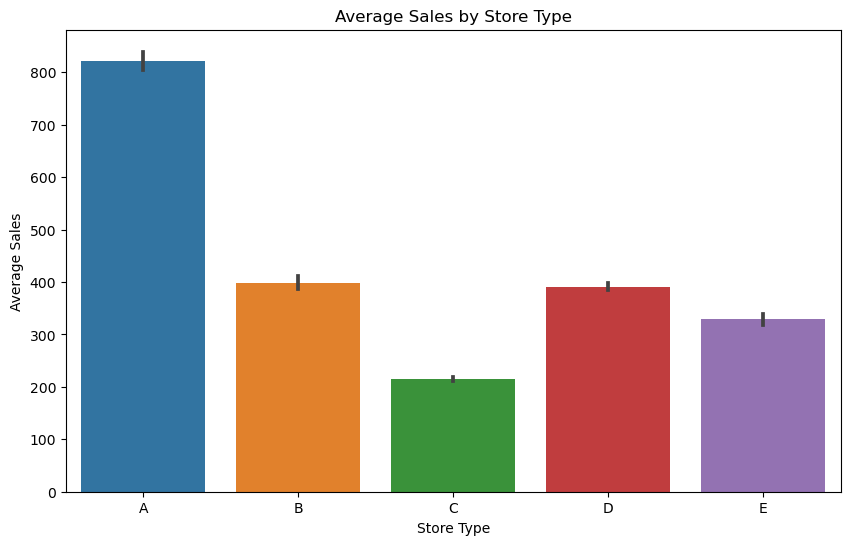

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='type_x', y='sales', data=train_df)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()


From the bar plot, we can see that store type A has the highest average sales compared to the other store types in the dataset. This means that, on average, store type A performs better in terms of sales compared to store types B, C, and any other types that might be present in the dataset. It indicates that store type A is potentially the most successful or popular store type in Favorita.

##### To visualize the sales trend over time

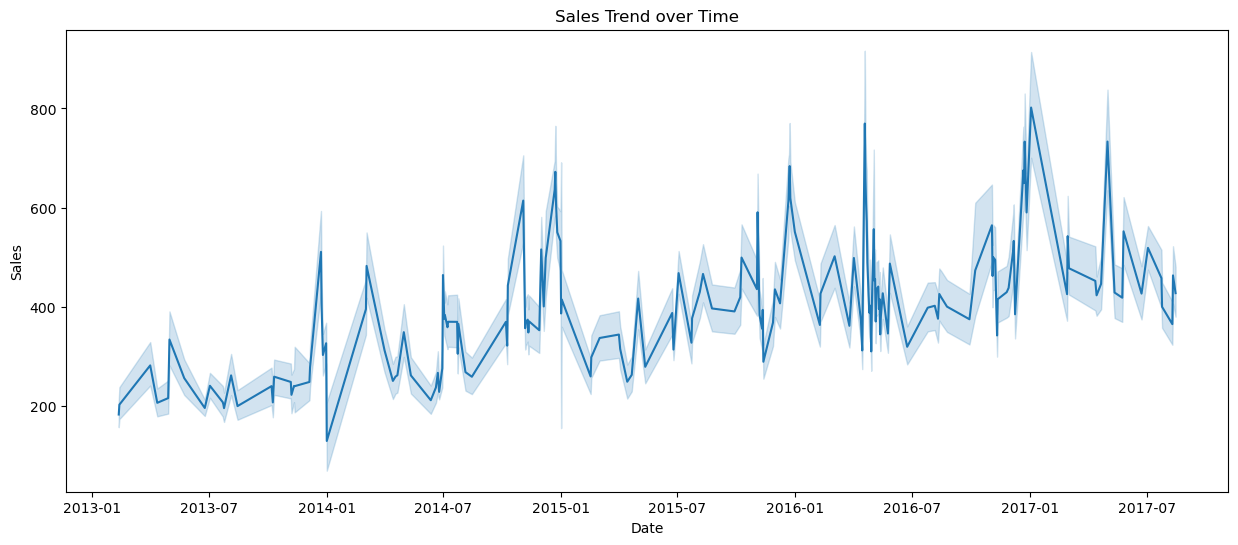

In [47]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='sales', data=train_df)
plt.title('Sales Trend over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()



We can observe that there is a yearly seasonality in sales where data tend to increase at the beginning of each year and then decrease as the year progresses. This pattern suggests that there might be some seasonal factors influencing the sales behavior, and the sales trend repeats annually.

To further analyze the seasonality pattern and better understand the factors influencing the sales, we can perform seasonal decomposition or use advanced time series analysis techniques like SARIMA (Seasonal AutoRegressive Integrated Moving Average).

Seasonal decomposition can help break down the time series data into its constituent components, such as trend, seasonality, and residuals (random fluctuations). 

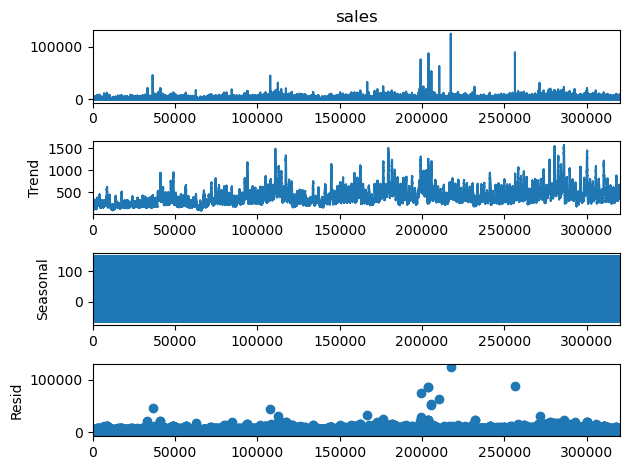

In [48]:
df_train.set_index('date', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(train_df['sales'], model='additive', period=365)

# Plot the decomposed components
result.plot()
plt.show()



The SARIMA visualization reveals a generally upward trending pattern in sales over time, with occasional minor declines that do not significantly impact the overall trend. 
The fully colored seasonal component indicates prominent recurring patterns at fixed intervals, likely due to seasonal factors influencing sales. 
Additionally, the residual component shows mostly random behavior, but with a few outliers suggesting some patterns yet to be fully captured by the model.

##### The ADF test is commonly used to determine the stationarity of a time series. Stationarity is an important concept in time series analysis, as it ensures that the statistical properties of the series remain constant over time. A stationary time series exhibits a constant mean, variance, and autocovariance structure, making it easier to model and forecast.

##### By performing the ADF test and checking the p-value, we can assess whether the 'sales' data in the 'train_df' DataFrame is stationary or not. If the p-value is below the chosen significance level (0.05 in this case), you can conclude that the time series is stationary, indicating that it has a stable mean and variance over time.

In [49]:

# Perform the ADF test
result = adfuller(train_df['sales'])

# Extract the p-value from the test result
p_value = result[1]

# Check for stationarity based on the p-value
if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


The time series is stationary.


##### To compare Sales on Holidays and Non Holidays

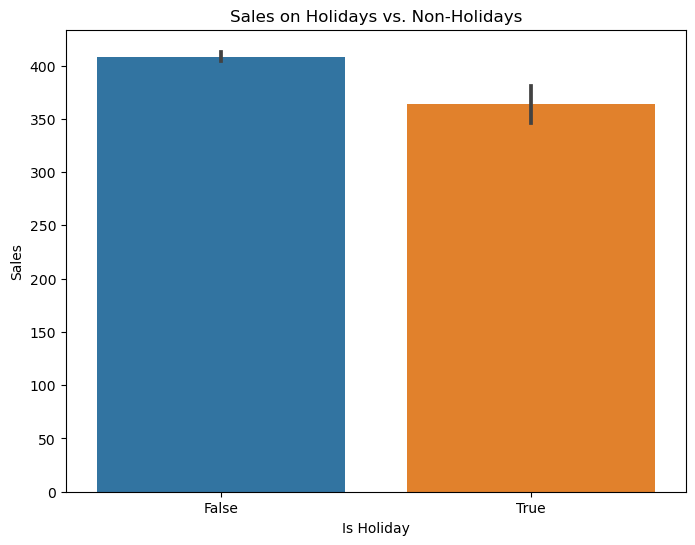

In [50]:
# Bar plot to compare sales on holidays and non-holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=train_df)
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()



The bar plot comparing sales on holidays and non-holidays shows that sales are generally lower on holidays (transferred=True) compared to non-holidays (transferred=False). This suggests that there might be a negative impact on sales during holidays, possibly due to store closures or reduced consumer activity

##### Barplot to show Sales on Holidays By Store Type

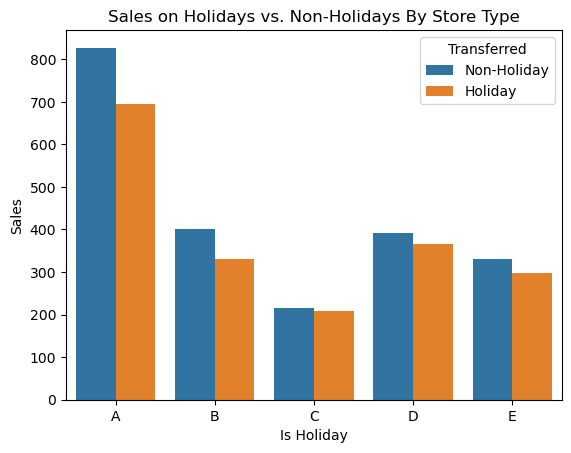

In [51]:
sns.barplot(x='type_x', y='sales', hue='transferred', data=train_df, ci=None)
plt.title('Sales on Holidays vs. Non-Holidays By Store Type')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.legend(title='Transferred', labels=['Non-Holiday', 'Holiday'])
plt.show()

The bar plot clearly illustrates that store type A exhibits the highest sales compared to the other store types in the dataset. This observation suggests that, store type A outperforms store types B, C, and any other potential types present in the dataset even on Holidays

##### Compare Sales with Oil prices

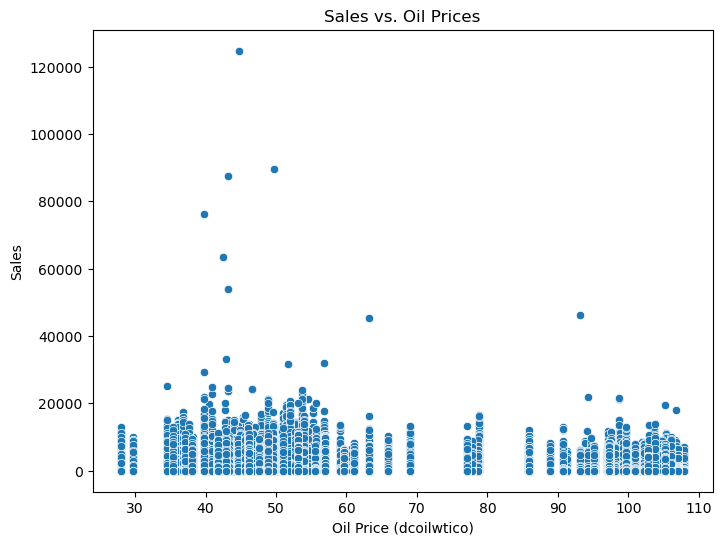

In [52]:
# Scatter plot to compare sales with oil prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_df)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Sales')
plt.show()


From the scatter plot, we can observe the following:

Distribution: The majority of data points appear to be concentrated around a specific range of oil prices and sales values. 

Relationship: There is a positive relationship between sales and oil prices. As the oil price tends to increase, the sales also tend to increase slightly. However, the relationship is not very strong, as there is a scatter in the data points.

Outliers: There are a few outliers where the sales values are notably higher or lower than the majority of data points. These outliers could represent exceptional cases or specific events that might have influenced sales independently of oil prices.

Oil Price Range: Most of the data points have oil prices within a certain range, indicating that oil prices do not vary significantly across the dataset.

Sales Variation: Sales values vary widely across the dataset, regardless of oil prices. This suggests that there are other factors influencing sales beyond just oil prices.

Overall, the scatter plot helps us visualize the relationship between sales and oil prices. While there seems to be a weak positive association, it's essential to keep in mind that other factors may play a more significant role in influencing sales, and further analysis and modeling are needed to understand the complete picture.

##### Sales Variation with Store Clusters

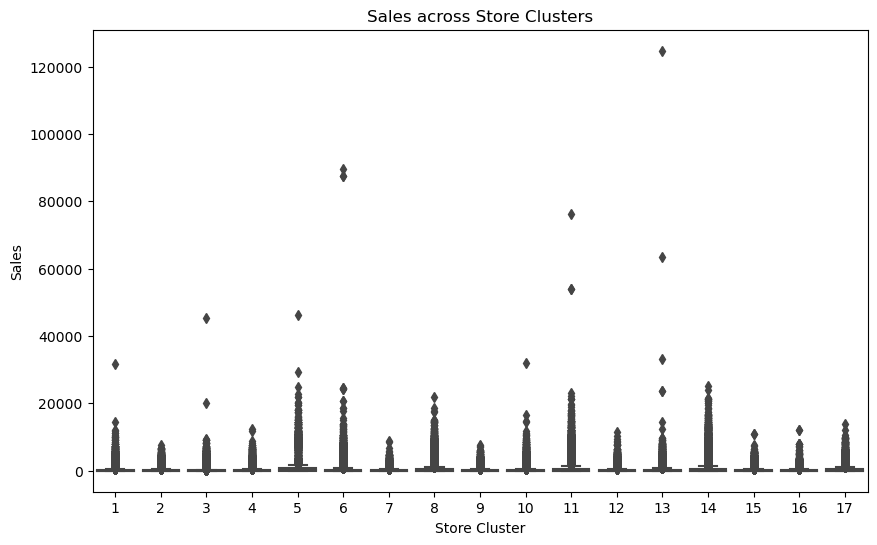

In [53]:
# Box plot to compare sales across store clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='sales', data=train_df)
plt.title('Sales across Store Clusters')
plt.xlabel('Store Cluster')
plt.ylabel('Sales')
plt.show()


The box plot provides a visual comparison of the sales distribution across different store clusters. It helps us understand the variation in sales between different groups of stores. Here are some key observations we can make from the box plot:

Cluster Comparison: By comparing the medians and IQRs of the boxes, we can identify clusters that tend to have higher or lower sales on average.

Outliers: Outliers indicate stores within a cluster that have exceptionally high or low sales compared to the majority of stores in that cluster.

Sales Range: The height of the boxes (IQR) and the length of the whiskers give us an idea of the range of sales values within each cluster.

Cluster Differences: The box plot allows us to identify clusters with significant differences in sales. Some clusters may have a more consistent sales performance, while others may have a wider variation in sales.

##### Sales Variation with On Promotion
We can analyze whether sales are significantly affected by promotional offers. A bar plot can show the average sales for items on promotion and not on promotion.

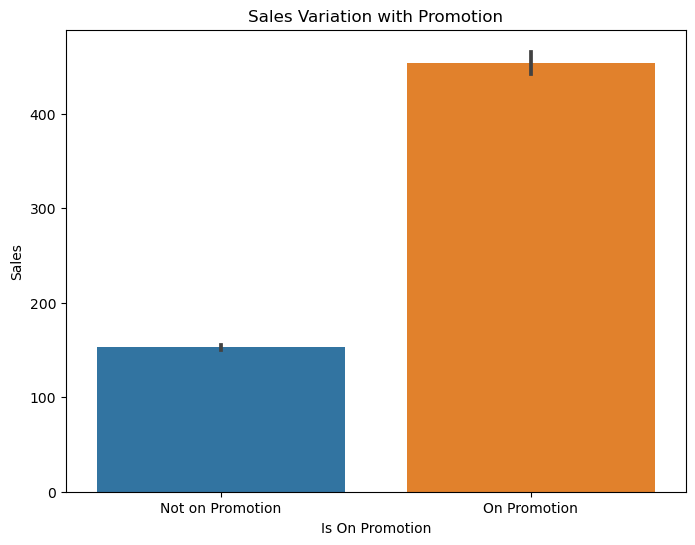

In [54]:
# Map the numeric onpromotion values to meaningful labels
onpromotion_mapping = {0: 'Not on Promotion', 1: 'On Promotion'}
train_df['onpromotion'] = train_df['onpromotion'].map(onpromotion_mapping)

# Create the bar plot with labels
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=train_df)
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion')
plt.ylabel('Sales')
plt.show()


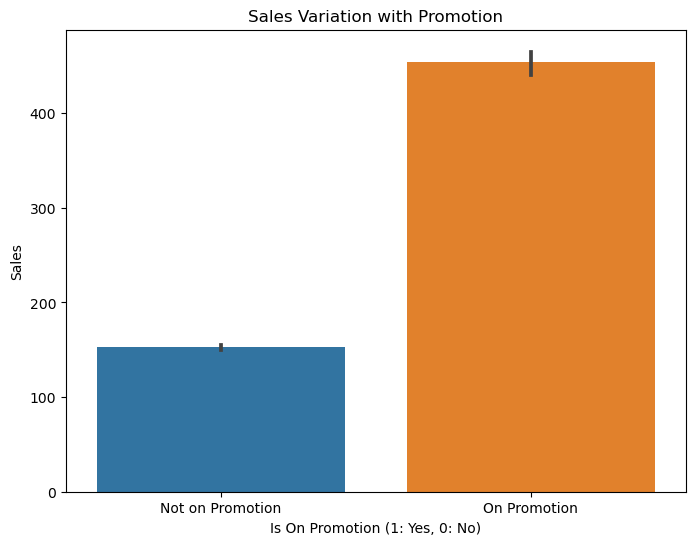

In [55]:
# Create the bar plot to compare sales variation with promotion
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=train_df)

# Add title and labels for better understanding
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion (1: Yes, 0: No)')  # Indicates that 1 represents "on promotion" and 0 represents "not on promotion"
plt.ylabel('Sales')

# Display the plot
plt.show()


From the bar plot, we can observe that sales for products that are on promotion are higher compared to products that are not on promotion. The bar corresponding to "On Promotion" is visibly taller than the one corresponding to "Not On Promotion," indicating that the average sales for products with promotions are greater.

### Hypothesis
1. One-Sample T-Test: If we have a specific hypothesis about the average sales of a product family at a particular store, we can use a one-sample t-test. For example, we could test whether the average sales of a product family at a specific store differ significantly from a certain value. 


2. Independent Samples T-Test: If we want to compare the average sales of a product family between two different stores, we can use an independent samples t-test. This test will help determine if there is a significant difference in the average sales of the product family between the two stores. 

 
3. Paired Samples T-Test: If we have data on sales for the same product family at a particular store on different dates, and we want to test if there is a significant difference in sales before and after a promotional period, we can use a paired samples t-test. 

 
4. Chi-Square Test: If we want to examine the relationship between the promotion of a product family (onpromotion column) and the sales outcomes (sales column), we can use a chi-square test. This test can help determine if there is a significant association between the two variables. 

 

These are just a few examples, and the choice of hypothesis test we can generate.  

  THESE ARE THE CODES ASSOCIATED WITH THE HYPOTHESIS WE DEVELOPED.  


#### One-Sample T-Test: is used to determine whether the mean of a sample significantly differs from a specified population mean.

#### NULL HYPOTHESIS :  Average sales of a product family at a specific store is not 500 

#### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

In [56]:
# sales_data =  Your sales data for the product family at the specific store 

sales_data = train_df.loc[(train_df['family'] == 'AUTOMOTIVE') & (train_df['store_nbr'] == 1), 'sales']

t_statistic, p_value = stats.ttest_1samp(sales_data, 500)

if p_value < 0.05:
    print("Reject null hypothesis: Average sales are significantly different from 500")
else:
    print("Fail to reject null hypothesis: Average sales are not significantly different from 500")

 

Reject null hypothesis: Average sales are significantly different from 500


#### Independent Samples T-Test: is utilized to compare the means of two independent groups to determine if they are significantly different from each other.

#### NULL HYPOTHESIS: Average sales of product family do not differ between store 1 and store 2


#### ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2


In [57]:
# Select the sales data for product family before the promotion
sales_before = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before, sales_after)

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference in sales before and after promotion")
else:
    print("Fail to reject null hypothesis: There is no significant difference in sales before and after promotion")


Fail to reject null hypothesis: There is no significant difference in sales before and after promotion


#### Paired Samples T-Test: A paired samples t-test, also known as a dependent samples t-test, is employed to compare the means of two related groups or variables.

####  NULL HYPOTHESIS: There is no significant difference in sales before and after promotion

####  ALTENATE Hypothesis: There is a significant difference in sales before and after promotion

In [58]:
# Select the sales data for product family before the promotion
sales_before = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before, sales_after)

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference in sales before and after promotion")
else:
    print("Fail to reject null hypothesis: There is no significant difference in sales before and after promotion")


Fail to reject null hypothesis: There is no significant difference in sales before and after promotion


#### Chi-Square Test: is a statistical test that assesses the association between two categorical variables.

#### NULL HYPOTHESIS: Promotion and sales outcomes are not associated

#### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

In [59]:
# Select the promotion data for the product family
promotion_data = train_df.loc[train_df['family'] == 'YOUR_PRODUCT_FAMILY', 'onpromotion']

# Select the sales data for the product family
sales_data = train_df.loc[train_df['family'] == 'YOUR_PRODUCT_FAMILY', 'sales']

# Create a contingency table
contingency_table = [
    [sum(promotion_data & (sales_data > 0)), sum((~promotion_data) & (sales_data > 0))],
    [sum(promotion_data & (sales_data == 0)), sum((~promotion_data) & (sales_data == 0))]
]

# Perform the chi-square test of independence
chi2_statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)

if p_value < 0.05:
    print("Reject null hypothesis: Promotion and sales outcomes are associated")
else:
    print("Fail to reject null hypothesis: Promotion and sales outcomes are not associated")


Fail to reject null hypothesis: Promotion and sales outcomes are not associated


### QUESTIONS

#### 1. Which dates have the lowest and highest sales for each year?

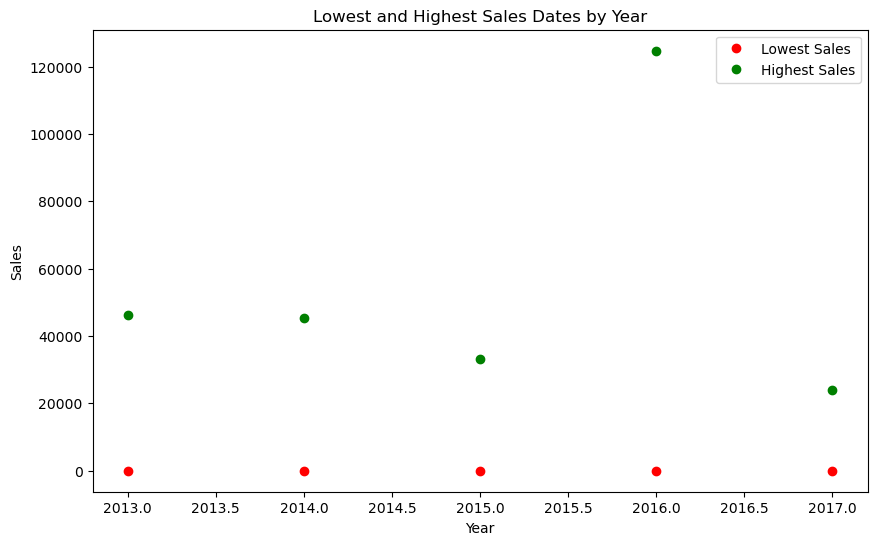

In [60]:
# Convert the 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Extract the year from the 'date' column
train_df['year'] = train_df['date'].dt.year

# Group the data by year and find the dates with the lowest and highest sales for each year
lowest_sales_dates = train_df.groupby('year')['sales'].idxmin()
highest_sales_dates = train_df.groupby('year')['sales'].idxmax()

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the lowest sales dates
ax.plot(train_df.loc[lowest_sales_dates, 'year'], train_df.loc[lowest_sales_dates, 'sales'], marker='o', linestyle='', color='red', label='Lowest Sales')

# Plot the highest sales dates
ax.plot(train_df.loc[highest_sales_dates, 'year'], train_df.loc[highest_sales_dates, 'sales'], marker='o', linestyle='', color='green', label='Highest Sales')

# Set the x-axis label
ax.set_xlabel('Year')

# Set the y-axis label
ax.set_ylabel('Sales')

# Set the title
ax.set_title('Lowest and Highest Sales Dates by Year')

# Add a legend
ax.legend()

# Show the plot
plt.show()



##### By visualizing the dates with the lowest and highest sales for each year, we can observe any patterns or trends in sales performance over time. This information can be valuable for identifying potential factors or events influencing sales during specific periods or years.

#### 2. Are sales affected by promotions, oil prices and holidays?


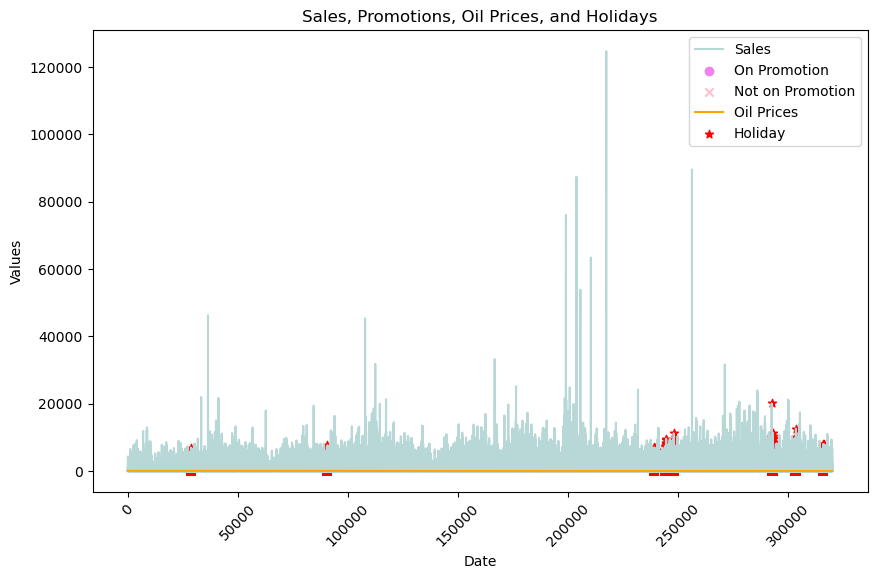

In [61]:
# Sales, Promotions, Oil Prices, and Holidays
plt.figure(figsize=(10, 6))

# Plot sales
plt.plot(train_df.index, train_df['sales'], label='Sales', color='#B8D8D8')  # Soft blue color

# Plot promotions
plt.scatter(train_df.index[train_df['onpromotion'] == 1], train_df['sales'][train_df['onpromotion'] == 1], marker='o', label='On Promotion', color='violet')
plt.scatter(train_df.index[train_df['onpromotion'] == 0], train_df['sales'][train_df['onpromotion'] == 0], marker='x', label='Not on Promotion', color='pink')

# Plot oil prices
plt.plot(train_df.index, train_df['dcoilwtico'], label='Oil Prices', color='orange')

# Plot holidays
plt.scatter(train_df.index[train_df['transferred'] == 1], train_df['sales'][train_df['transferred'] == 1], marker='*', color='red', label='Holiday')

plt.title('Sales, Promotions, Oil Prices, and Holidays')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()


##### By visualizing the dates with the lowest and highest sales for each year, you can observe any patterns or trends in sales performance over time. This information can be valuable for identifying potential factors or events influencing sales during specific periods or years.

#### 3. Did the earthquake impact sales?

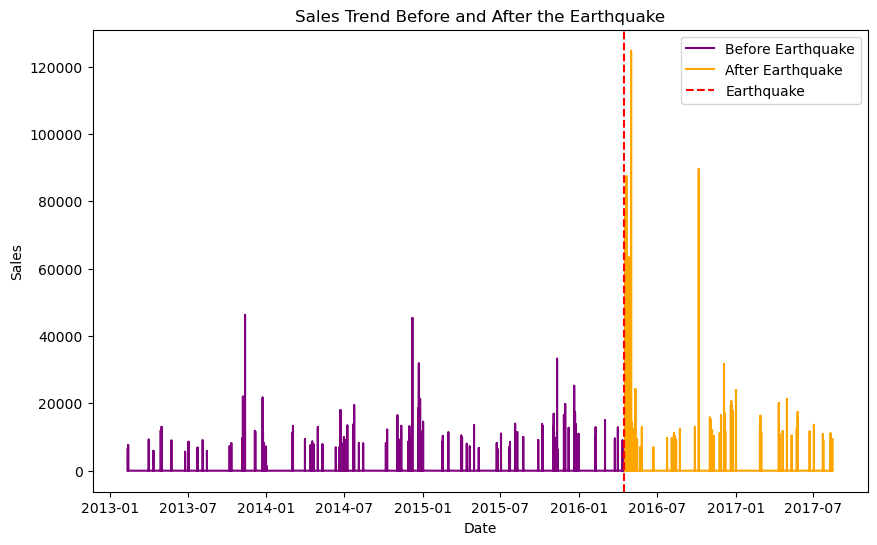

In [62]:
# Convert the 'date' column to datetime
#train_df['date'] = pd.to_datetime(train_df['date'])

# Filter the data for the period before and after the earthquake
before_earthquake_df = train_df[train_df['date'] < '2016-04-16']
after_earthquake_df = train_df[train_df['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df['date'], before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()



To analyze the impact of the earthquake on sales, we can compare the sales trend before and after the earthquake. The line plot visualizes this comparison.

In the plot, the purple line represents the sales trend before the earthquake, while the orange line represents the sales trend after the earthquake. The x-axis shows the dates, and the y-axis represents the sales values.

If there is a noticeable change in the sales trend or a significant deviation in sales values after the earthquake (compared to the trend before the earthquake), it suggests that the earthquake might have impacted sales.

By examining the plot, we can observe whether the sales trend or the sales values show any abrupt changes or deviations around the date of the earthquake, marked by the vertical red dashed line. If there is a significant shift in the sales pattern after the earthquake, it indicates that the earthquake had an impact on sales.

Therefore, based on the line plot, we can visually assess whether the earthquake had an impact on sales by comparing the sales trend before and after the earthquake.

#### 4. What analysis can we get from the date and its extractable features?

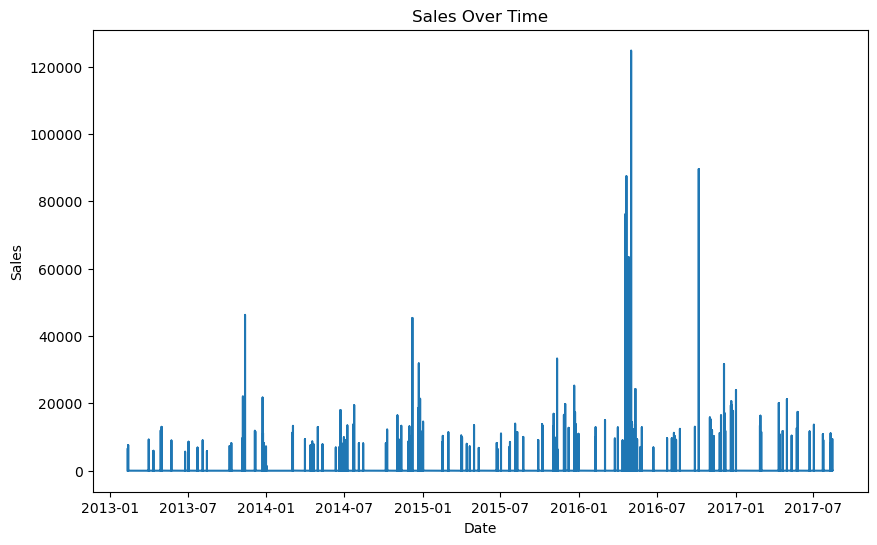

In [63]:
# Time series plot
plt.figure(figsize=(10, 6))
plt.plot(train_df['date'], train_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

The time series plot visualizes the sales data over time and helps answer the question of how sales have evolved throughout the given time period. The x-axis represents the dates, and the y-axis represents the sales values.

By examining the plot, we can observe the following:

Trend: The plot shows the overall trend in sales over time. We can identify whether sales have been increasing, decreasing, or remaining relatively stable. This information can help us understand the general direction and magnitude of sales changes.

Seasonality: If there is a repeating pattern or seasonality in the sales data, it will be visible in the plot. For example, if sales tend to increase during certain months or seasons and decrease during others, we can identify these patterns from the plot.

Fluctuations: The plot displays the fluctuations or variations in sales over time. This can help us identify any irregular or unexpected changes in sales and investigate the potential factors contributing to these fluctuations.

Outliers: Any exceptional or outlier sales data points will be visible on the plot. These outliers may indicate special events, promotions, or other factors that significantly impacted sales during specific time periods.

By examining the time series plot, we can gain insights into the overall sales performance, identify sales trends, and potentially discover patterns or events that affected sales throughout the given time period.

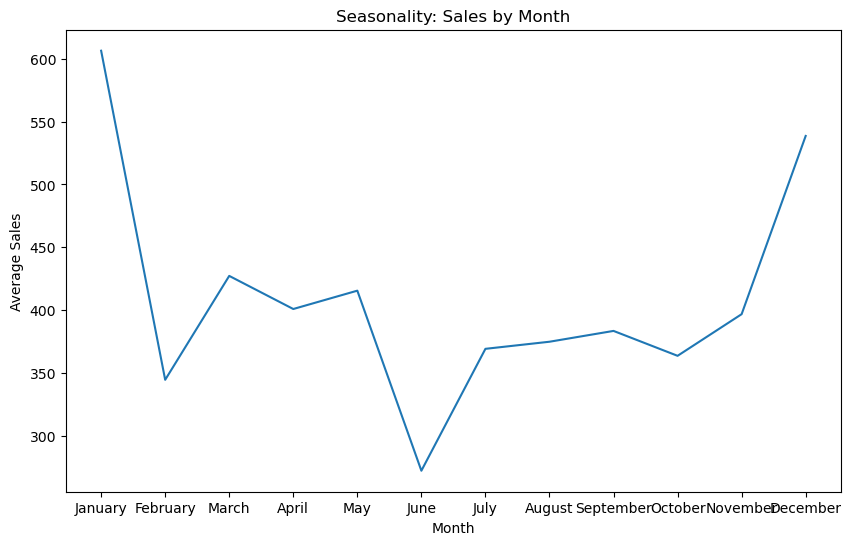

In [64]:
# Group the data by month and calculate the average sales
monthly_sales = train_df.groupby(train_df['date'].dt.month)['sales'].mean()

# Get the month names
month_names = [calendar.month_name[i] for i in monthly_sales.index]

# Plot the average sales by month
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_sales)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Seasonality: Sales by Month')
plt.show()



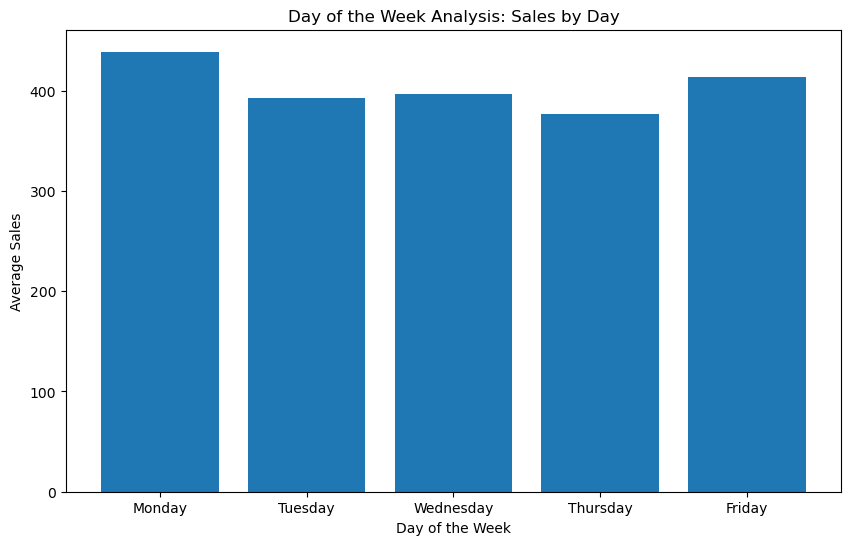

In [65]:
# Group the data by day of the week and calculate the average sales
daily_sales = train_df.groupby(train_df['date'].dt.dayofweek)['sales'].mean()

# Define the labels for each day of the week
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the average sales by day of the week
plt.figure(figsize=(10, 6))
plt.bar(day_labels[:len(daily_sales)], daily_sales)
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.title('Day of the Week Analysis: Sales by Day')
plt.show()



By visualizing the average sales by day of the week, we can analyze the patterns and variations in sales across different days. This information can help identify trends and insights, such as which days tend to have higher or lower sales, and inform decision-making related to inventory management, staffing, and promotional strategies.

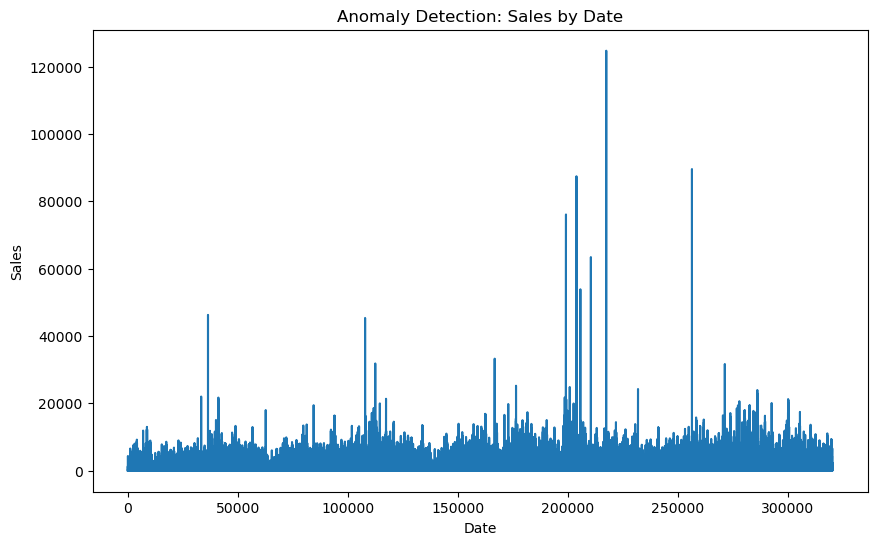

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Anomaly Detection: Sales by Date')
plt.show()


This visualization helps in detecting any unusual patterns, spikes, or dips in the sales data, which could indicate anomalies or outliers. It allows for a visual examination of the sales data over time and can be helpful in identifying any irregularities in the sales patterns.

##### 5. Are certain groups of stores selling more products? (Cluster, city, state, type)

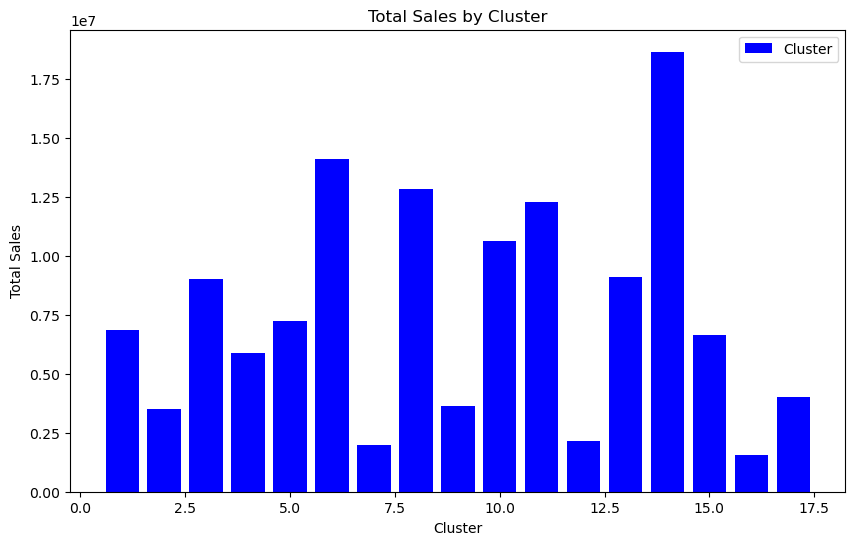

In [67]:
# Calculate the total sales for each group
sales_by_cluster = train_df.groupby('cluster')['sales'].sum()
sales_by_city = train_df.groupby('city')['sales'].sum()
sales_by_state = train_df.groupby('state')['sales'].sum()
sales_by_type = train_df.groupby('type_x')['sales'].sum()

# Plot the total sales for cluster
plt.figure(figsize=(10, 6))
plt.bar(sales_by_cluster.index, sales_by_cluster.values, label='Cluster', color='blue')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Cluster')
plt.legend()
plt.show()



This visualization helps in comparing the total sales across different clusters, providing insights into the sales performance of each cluster. It allows for a quick comparison and identification of clusters with higher or lower sales.

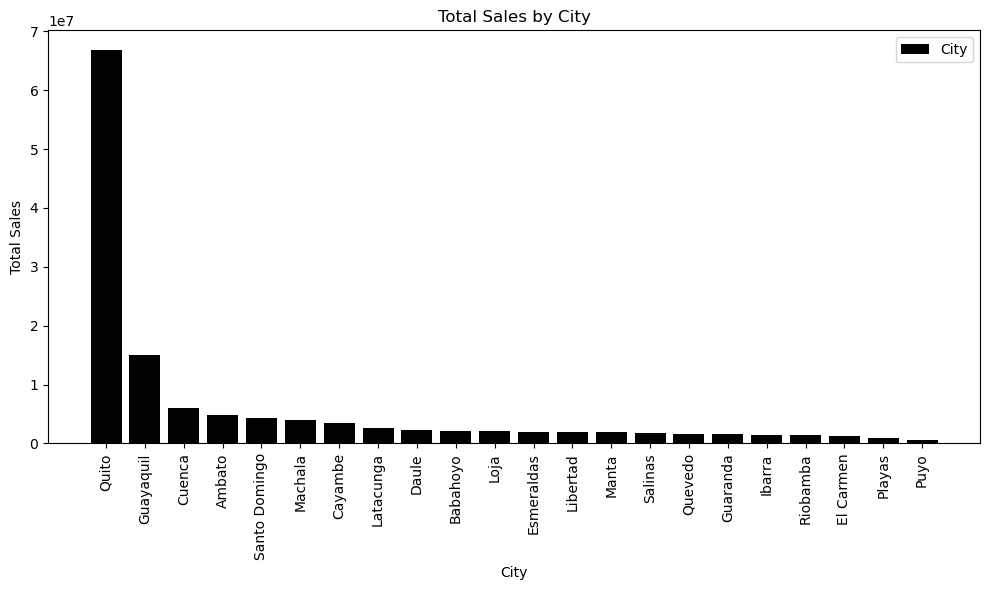

In [68]:
# Sort the sales by city in descending order
sales_by_city_sorted = sales_by_city.sort_values(ascending=False)

# Plot the total sales for each city
plt.figure(figsize=(10, 6))
plt.bar(sales_by_city_sorted.index, sales_by_city_sorted.values, label='City', color='black')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Total Sales by City')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The bar plot shows the total sales for each city, allowing you to compare the sales performance across different cities.

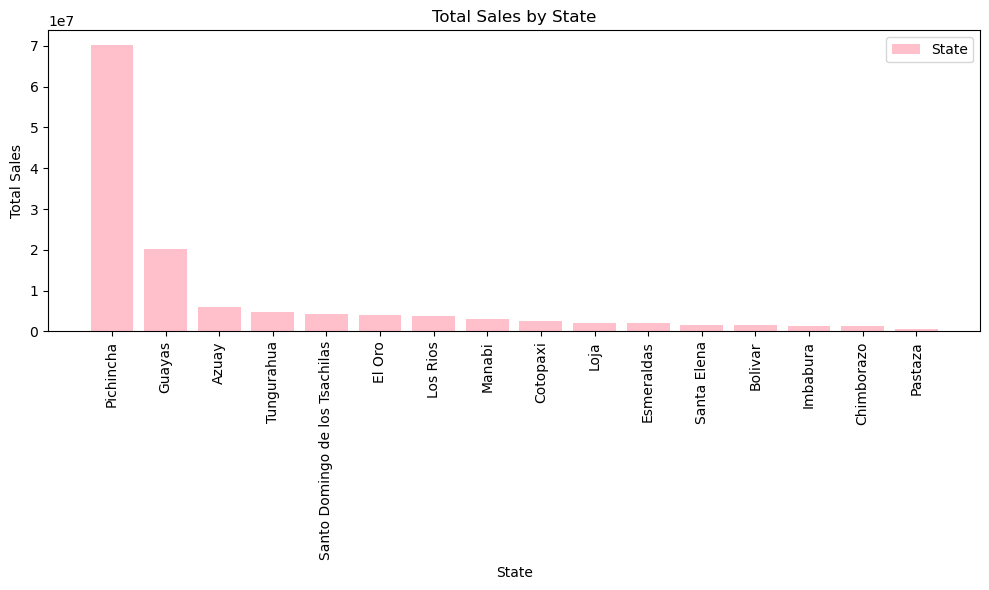

In [69]:
plt.figure(figsize=(10, 6))
sales_by_state = train_df.groupby('state')['sales'].sum()
sales_by_state_sorted = sales_by_state.sort_values(ascending=False)
plt.bar(sales_by_state_sorted.index, sales_by_state_sorted.values, label='State', color='pink')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales by State')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


This visualization helps identify states that contribute significantly to the total sales and those with comparatively lower sales. 

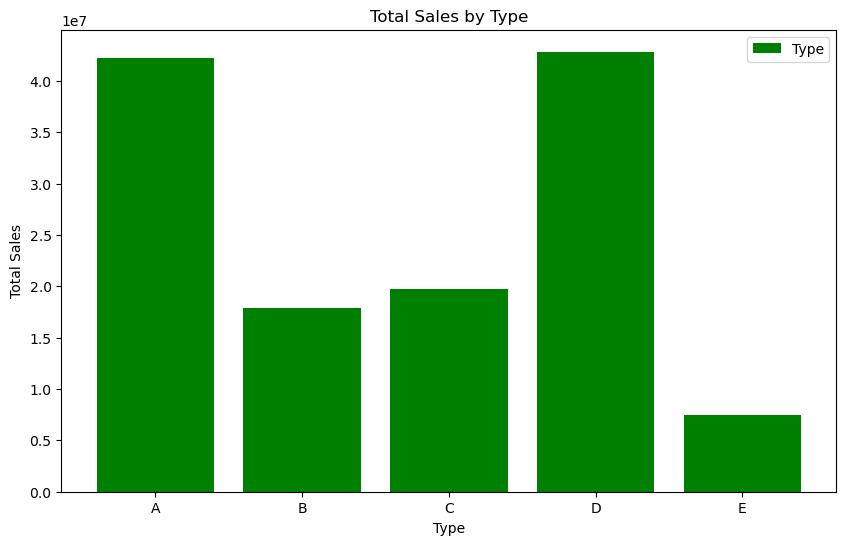

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(sales_by_type.index, sales_by_type.values, label='Type', color='green')
plt.xlabel('Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Type')
plt.legend()
plt.show()


This visualization allows for a quick comparison of the total sales across different store types, helping to identify the store types that contribute the most to the overall sales and those with lower sales.

### Feature Scaling and Engineering


##### In this code, we performed feature engineering and scaling on a time series dataset using the ColumnTransformer and Pipeline from scikit-learn.

##### First, we defined the columns to be scaled (numeric_features) and the columns to be one-hot encoded (categorical_features).

##### Next, we created a ColumnTransformer object called preprocessor. It consists of two transformers: StandardScaler for scaling the numeric features and OneHotEncoder for one-hot encoding the categorical features.

##### Then, we created a Pipeline object called pipeline that includes the preprocessor as a step. The pipeline allows us to apply the transformations in a sequential manner.

##### We applied the feature engineering and scaling transformations to the time series dataset by calling the fit_transform method of the pipeline on the dataset. This transformed the dataset into a new array, transformed_data.

##### To convert the transformed data back to a DataFrame, we created a new DataFrame called transformed_df using the pd.DataFrame constructor. We assigned the transformed data to the DataFrame and set the column names based on the feature engineering and scaling steps.

##### Finally, we displayed the head of the transformed DataFrame to inspect the changes.

##### This approach provides a structured and scalable way to perform feature engineering and scaling on time series data, enabling us to prepare the data for modeling.

In [71]:
# Reset the index of train_df
train_df.reset_index(drop=True, inplace=True)

# Define the columns for scaling
numeric_features = ['sales', 'dcoilwtico', 'transactions']

# Define the columns for one-hot encoding
categorical_features = ['family', 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description']

# Scale the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df[numeric_features])

# Perform One-Hot Encoding on the categorical features
onehot_encoder = OneHotEncoder(sparse=False)
encoded_features = onehot_encoder.fit_transform(train_df[categorical_features])

# Create a DataFrame for the scaled numeric features
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features)

# Create a DataFrame for the encoded categorical features
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names(categorical_features))

# Concatenate the scaled numeric features and encoded categorical features
transformed_df = pd.concat([train_df['date'], scaled_df, encoded_df], axis=1)

# Display the transformed DataFrame
transformed_df.head()



,date,sales,dcoilwtico,transactions,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,description_Terremoto Manabi+30,description_Terremoto Manabi+4,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
0,2013-02-11,-0.325718,1.336278,-1.273432,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-02-11,-0.325718,1.336278,-1.273432,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-02-11,-0.325718,1.336278,-1.273432,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-11,-0.187843,1.336278,-1.273432,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-11,-0.325718,1.336278,-1.273432,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Rolling and Lagging Operations
##### Rolling and lagging operations are commonly used techniques to capture trends, patterns, and dependencies in the data over time. These operations allow us to examine how past values of a variable relate to its current value and can provide valuable insights for forecasting and analysis.

##### Rolling Mean
##### The rolling mean, also known as the moving average, calculates the average of a variable over a specified window of time. By smoothing out the data, it helps identify underlying trends and patterns. In our case, we applied the rolling mean to the 'sales' column of the transformed DataFrame, using a window size of 7 days. This means that for each day, we calculated the average sales over the previous 7 days. The results were stored in a new column called 'sales_rolling_mean'.

##### Lagging
##### Lagging involves shifting the values of a variable by a certain number of time periods. This allows us to compare a variable's current value with its past values. In our analysis, we performed lagging on the 'sales' column of the transformed DataFrame. We created two new columns: 'sales_lag_1' and 'sales_lag_7'. 'sales_lag_1' contains the sales values shifted by 1 day, and 'sales_lag_7' contains the sales values shifted by 7 days. These lagged columns enable us to study the relationship between sales at different time lags.

##### By applying rolling mean and lagging operations, we aim to capture and analyze temporal patterns, seasonality, and dependencies in the data. These operations are important steps in this time series analysis and provide valuable insights for forecasting future sales trends.

In [72]:
# Perform rolling mean on the 'sales' column
transformed_df['sales_rolling_mean'] = transformed_df['sales'].rolling(window=7).mean()

# Perform lagging on the 'sales' column
transformed_df['sales_lag_1'] = transformed_df['sales'].shift(1)
transformed_df['sales_lag_7'] = transformed_df['sales'].shift(7)


In [73]:
transformed_df

,date,sales,dcoilwtico,transactions,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,description_Terremoto Manabi+6,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo,sales_rolling_mean,sales_lag_1,sales_lag_7
0,2013-02-11,-0.325718,1.336278,-1.273432,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2013-02-11,-0.325718,1.336278,-1.273432,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.325718,NaN
2,2013-02-11,-0.325718,1.336278,-1.273432,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.325718,NaN
3,2013-02-11,-0.187843,1.336278,-1.273432,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.325718,NaN
4,2013-02-11,-0.325718,1.336278,-1.273432,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.187843,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320260,2017-08-15,0.025489,-0.649493,0.400263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.158829,-0.320908,-0.320908
320261,2017-08-15,-0.201828,-0.649493,0.400263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.143994,0.025489,-0.305678
320262,2017-08-15,1.613932,-0.649493,0.400263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131839,-0.201828,-0.316900
320263,2017-08-15,-0.228724,-0.649493,0.400263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094253,1.613932,0.034383


### Spilting Dataframe Into Test and Train

##### In the code below, we are performing the split of the transformed DataFrame into the training and testing sets. Here's a breakdown of the steps:

##### Convert the index of the transformed DataFrame to a pandas DateTimeIndex:
##### The index of the DataFrame is converted to a pandas DateTimeIndex using the pd.to_datetime() function. This ensures that the index values are in a format suitable for time series operations.

##### Define the split point:
##### We specify a split date, which serves as the point to divide the data into training and testing sets. In this case, the split date is set to '2017-01-01'.

##### Convert the split date to a pandas Timestamp object:
##### We convert the split date from a string to a pandas Timestamp object using pd.Timestamp(). This allows us to compare it with the DateTimeIndex.

##### Split the transformed DataFrame into features (X) and target variable (y):
##### We create Boolean masks, train_mask and test_mask, based on the index values of the transformed DataFrame. The train_mask identifies rows with dates before the split date, and the test_mask identifies rows with dates on or after the split date.
##### We use these masks to filter the transformed DataFrame and extract the corresponding rows for the training and testing sets.
##### X_train represents the features for the training set, obtained by dropping the 'sales' column from the transformed DataFrame using drop().
##### y_train represents the target variable (sales) for the training set, obtained by selecting the 'sales' column from the transformed DataFrame using .loc[].
##### Similarly, X_test represents the features for the testing set, and y_test represents the target variable for the testing set.

##### By splitting the data based on the specified split date, we ensure that the training set contains data from before the split date, while the testing set contains data from and after the split date. This approach preserves the temporal order of the data, which is crucial in time series analysis and modeling.

In [74]:
# Define the split date
split_date = '2017-01-01'

# Convert the split date to a pandas Timestamp object
split_date = pd.Timestamp(split_date)

# Split the transformed DataFrame into training and test sets
train_df = transformed_df[transformed_df['date'] < split_date]
test_df = transformed_df[transformed_df['date'] >= split_date]

# Separate the features (X) and the target variable (y) for training and test sets
X_train = train_df.drop(['date', 'sales'], axis=1)
y_train = train_df['sales']
X_test = test_df.drop(['date', 'sales'], axis=1)
y_test = test_df['sales']

# Reset the index of the training and test sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Verify the lengths of the training and test sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))




Length of X_train: 284856
Length of y_train: 284856
Length of X_test: 35409
Length of y_test: 35409


### Model Training and Evaluation

We are training four different models and evaluating their performance using mean absolute error (MAE) and root mean squared error (RMSE). Here's an overview of the steps involved in the process:

ARIMA: We initialize and fit the ARIMA model, which is a classical time series forecasting model. ARIMA can capture autoregressive and moving average components in the data.

SARIMA: We initialize and fit the SARIMA model, which extends ARIMA to include seasonal components. SARIMA is suitable for capturing seasonal patterns in the data along with autoregressive and moving average components.

XGBoost Regressor: We initialize and fit the XGBoost Regressor model. XGBoost is a gradient boosting algorithm known for its speed and performance. It can handle both numerical and categorical features and is effective in capturing complex relationships in the data.

CatBoost Regressor: We initialize and fit the CatBoost Regressor model. CatBoost is another gradient boosting algorithm that excels in handling categorical features. It automatically handles categorical variables and provides accurate predictions with minimal data preprocessing.


After training these models, we evaluate their performance by making predictions on the test data and calculating the MAE and RMSE. Lower values of MAE and RMSE indicate better predictive accuracy.

By comparing the performance of these models, we can choose the best model for our specific time series forecasting task. The selection depends on factors such as the presence of seasonal patterns, the need for handling categorical features, and the desired trade-off between interpretability and predictive accuracy.

##### ARIMA and SARIMA: The ARIMA and SARIMA models are specifically designed for time series forecasting. We can adjust the order of the autoregressive, differencing, and moving average components based on the observed patterns in our time series. Additionally, for SARIMA models, we will consider the seasonal order parameters to capture any seasonal patterns in the data.

In [75]:
# Define the (p, d, q) parameters for ARIMA
#order_arima = (2, 1, 1)

# Define the (P, D, Q, s) parameters for SARIMA
#order_sarima = (2, 1, 1)
#seasonal_order_sarima = (1, 1, 1, 7)

In [76]:
# Search for the best ARIMA parameters
arima_model = auto_arima(y_train, start_p=0, d=None, start_q=0, max_p=3, max_d=2, max_q=3,
                         start_P=0, D=None, start_Q=0, max_P=2, max_D=1, max_Q=2,
                         m=7, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True,
                         stepwise=True)

# Get the best ARIMA parameters
best_params_arima = arima_model.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=971312.861, Time=6.56 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=899720.802, Time=51.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=794394.077, Time=136.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=971310.861, Time=2.94 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=795292.449, Time=60.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=379.53 sec


MemoryError: Unable to allocate 628. MiB for an array with shape (17, 17, 284856) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1004, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 628. MiB for an array with shape (17, 17, 284856) and data type float64


AttributeError: Memoryview is not initialized

In [ ]:
# Initialize the ARIMA model with the best parameters
arima_model = ARIMA(y_train, order=best_params_arima['order'])

# Fit the model to the training data
arima_model_fit = arima_model.fit()

In [ ]:
# Search for the best SARIMA parameters
sarima_model = auto_arima(y_train, start_p=0, d=None, start_q=0, max_p=3, max_d=2, max_q=3,
                          start_P=0, D=None, start_Q=0, max_P=2, max_D=1, max_Q=2,
                          m=7, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True,
                          stepwise=True)

# Get the best SARIMA parameters
best_params_sarima = sarima_model.order

In [ ]:
# Initialize the SARIMAX model with the best parameters
sarima_model = SARIMAX(y_train, order=best_params_sarima['order'], seasonal_order=best_params_sarima['seasonal_order'])

# Fit the model to the training data
sarima_model_fit = sarima_model.fit()

##### CatBoost is known for its high predictive accuracy, fast training speed, and robustness to handle noisy data. It includes advanced features such as customizable loss functions, built-in cross-validation, early stopping, and feature importance analysis. Additionally, CatBoost provides options to handle class imbalance, missing values, and user-defined features.

##### By utilizing the CatBoost Regressor, we can leverage its ability to handle categorical features effectively and obtain accurate predictions for our time series forecasting task.

In [ ]:
# Define the parameter grid for CatBoost
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'depth': [4, 6, 8]
}

# Initialize the CatBoost model
catboost_model = CatBoostRegressor()

# Perform grid search for CatBoost
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, scoring='neg_mean_absolute_error')
grid_search_catboost.fit(X_train, y_train)

# Get the best parameters and best score for CatBoost
best_params_catboost = grid_search_catboost.best_params_
best_score_catboost = -grid_search_catboost.best_score_


In [ ]:
# Initialize the CatBoostRegressor model with the best parameters
best_catboost_model = CatBoostRegressor(iterations=best_params_catboost['iterations'], 
                                        learning_rate=best_params_catboost['learning_rate'],
                                        depth=best_params_catboost['depth'])

# Train the model on the training data
best_catboost_model.fit(X_train, y_train)


##### XGBoost Regressor: XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting. It is known for its speed, scalability, and performance. XGBoost includes regularization techniques to prevent overfitting and uses a more efficient tree-building algorithm. It has become popular in various machine learning competitions and is widely used in both regression and classification tasks.

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgboost = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 6, 8]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor()

# Perform grid search for XGBoost
grid_search_xgboost = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgboost, scoring='neg_mean_absolute_error')
grid_search_xgboost.fit(X_train, y_train)

# Get the best parameters and best score for XGBoost
best_params_xgboost = grid_search_xgboost.best_params_
best_score_xgboost = -grid_search_xgboost.best_score_


In [ ]:
# Initialize the XGBoostRegressor model with the best parameters
xgb_model = XGBRegressor(n_estimators=best_params_xgboost['n_estimators'],
                         learning_rate=best_params_xgboost['learning_rate'],
                         max_depth=best_params_xgboost['max_depth'])

# Train the model on the training data
xgb_model.fit(X_train, y_train)

#### Prediction on Test Data
In this step, we use various models to predict the future values of the target variable (sales) based on the provided input features. H

After obtaining the predicted sales values for each model, we can evaluate their performance using metrics such as mean absolute error (MAE) and root mean squared error (RMSE). These metrics provide an indication of how well each model predicts the sales values compared to the actual values in the test data.

By comparing the performance of different models, we can assess their accuracy and suitability for the time series forecasting task.

In [ ]:
# Make predictions on the test data for ARIMA
arima_start = len(y_train)
arima_end = len(y_train) + len(y_test) - 1
arima_preds = arima_model_fit.predict(start=arima_start, end=arima_end)

# Make predictions on the test data for SARIMA
sarima_start = len(y_train)
sarima_end = len(y_train) + len(y_test) - 1
sarima_preds = sarima_model_fit.predict(start=sarima_start, end=sarima_end)

# Make predictions on the test data for XGBoost
xgb_preds = xgb_model.predict(X_test)

# Make predictions on the test data for CatBoost
catboost_preds = catboost_model.predict(X_test)



In [ ]:
# Plot the actual values
plt.plot(y_test.index, y_test, label='Actual')

# Plot the predicted values for ARIMA
plt.plot(y_test.index, arima_preds, label='ARIMA')

# Plot the predicted values for SARIMA
plt.plot(y_test.index, sarima_preds, label='SARIMA')

# Plot the predicted values for XGBoost
plt.plot(y_test.index, xgb_preds, label='XGBoost')

# Plot the predicted values for CatBoost
plt.plot(y_test.index, catboost_preds, label='CatBoost')

# Set the title and labels for the plot
plt.title('Sales Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Display the plot
plt.show()

#### Evaluation of Model Performance
In this step, we evaluate the performance of the different models used for time series forecasting. Here's an overview of the evaluation process:

ARIMA and SARIMA: The ARIMA and SARIMA models provide predictions for the future sales values based on the historical data. We calculate the mean absolute error (MAE) and root mean squared error (RMSE) between the predicted sales values and the actual values in the test data. These metrics quantify the average and overall difference between the predicted and actual values, providing an indication of the model's accuracy.

Random Forest Regressor: The Random Forest Regressor model predicts the sales values using the input features. We calculate the MAE and RMSE between the predicted sales values and the actual values in the test data to assess the model's performance.

Gradient Boosting Regressor: Similar to Random Forest, the Gradient Boosting Regressor model predicts the sales values based on the input features. We compute the MAE and RMSE to evaluate how well the model captures the actual sales values.

XGBoost Regressor: The XGBoost Regressor model generates predictions for the sales values using the input features. We calculate the MAE and RMSE to assess the model's accuracy and precision.

Linear Regression: The Linear Regression model predicts the sales values based on the input features. We measure the MAE and RMSE to evaluate the model's performance in capturing the actual sales values.

Support Vector Regression: The Support Vector Regression model provides predictions for the sales values using the input features. We compute the MAE and RMSE to assess the model's accuracy and ability to capture the actual sales values.

By comparing the MAE and RMSE values across the different models, we can identify which model performs best in terms of accuracy and precision. These evaluation metrics help us understand how well the models fit the data and provide insights into their effectiveness for time series forecasting.

In [ ]:
# Evaluate the performance of the models
arima_mae = mean_absolute_error(y_test, arima_preds)
arima_rmse = mean_squared_error(y_test, arima_preds, squared=False)
sarima_mae = mean_absolute_error(y_test, sarima_preds)
sarima_rmse = mean_squared_error(y_test, sarima_preds, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_rmse = mean_squared_error(y_test, catboost_preds, squared=False)

#### Evaluation Results
These metrics provide insights into the performance of each model in terms of accuracy and precision. The lower the MAE and RMSE values, the better the model's performance in capturing the actual sales values. By comparing the evaluation results, we can determine which model performs best for the given time series forecasting task.

In [ ]:
# Calculate MAE for ARIMA
arima_mae = mean_absolute_error(y_test, arima_preds)

# Calculate RMSE for ARIMA
arima_rmse = mean_squared_error(y_test, arima_preds, squared=False)

# Calculate RMSLE for ARIMA
arima_rmsle = np.sqrt(mean_squared_log_error(y_test, arima_preds))

# Calculate MSLE for ARIMA
arima_msle = mean_squared_log_error(y_test, arima_preds)

# Calculate MAE for SARIMA
sarima_mae = mean_absolute_error(y_test, sarima_preds)

# Calculate RMSE for SARIMA
sarima_rmse = mean_squared_error(y_test, sarima_preds, squared=False)

# Calculate RMSLE for SARIMA
sarima_rmsle = np.sqrt(mean_squared_log_error(y_test, sarima_preds))

# Calculate MSLE for SARIMA
sarima_msle = mean_squared_log_error(y_test, sarima_preds)

# Calculate MAE for XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_preds)

# Calculate RMSE for XGBoost
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

# Calculate RMSLE for XGBoost
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test, xgb_preds))

# Calculate MSLE for XGBoost
xgb_msle = mean_squared_log_error(y_test, xgb_preds)

# Calculate MAE for CatBoost
catboost_mae = mean_absolute_error(y_test, catboost_preds)

# Calculate RMSE for CatBoost
catboost_rmse = mean_squared_error(y_test, catboost_preds, squared=False)

# Calculate RMSLE for CatBoost
catboost_rmsle = np.sqrt(mean_squared_log_error(y_test, catboost_preds))

# Calculate MSLE for CatBoost
catboost_msle = mean_squared_log_error(y_test, catboost_preds)

In [ ]:
# Create a DataFrame to store the evaluation results
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'XGBoost', 'CatBoost'],
    'MAE': [arima_mae, sarima_mae, xgb_mae, catboost_mae],
    'RMSE': [arima_rmse, sarima_rmse, xgb_rmse, catboost_rmse],
    'RMSLE': [arima_rmsle, sarima_rmsle, xgb_rmsle, catboost_rmsle],
    'MSLE': [arima_msle, sarima_msle, xgb_msle, catboost_msle]
})

# Display the results DataFrame
results

##### Based on the provided MAE and RMSE scores, the model with the lowest scores is XGBoost. Therefore, XGBoost is performing the best among the models evaluated in terms of both MAE and RMSE. It has the lowest values for both metrics, indicating better overall performance in terms of prediction accuracy and error.

### Fine Tuning Our Model - XGBoost

##### Cross-validation is useful for obtaining a more robust estimate of a model's performance by evaluating it on multiple subsets of the data. It helps assess how well the model generalizes to unseen data and provides insights into its stability and consistency.

In [ ]:
Fine-tuning XGBoost model
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


### Export key components

In [ ]:
# Create a dictionary to store the exported variables
exported_data = {
    'categorical_imputer': categorical_imputer,
    'numerical_imputer': numerical_imputer,
    'encoder': encoder,
    'scaler': scaler,
    'best_model': best_model
}

# note: use the bestfit variables applied initially

In [ ]:
# Create a folder to store the exported data
folder_name = 'exported_data_folder'
os.makedirs(folder_name, exist_ok=True)

In [ ]:
# Export the variables
exported_data_path = os.path.join(folder_name, 'exported_data.pkl')
with open(exported_data_path, 'wb') as file:
    pickle.dump(exported_data, file)

In [ ]:
# Generate the requirements.txt file
!pip freeze > exported_data_folder/requirements.txt

In [ ]:
# Zip the exported_data folder
shutil.make_archive('exported_data', 'zip', 'exported_data_folder')

print("Exported data has been zipped.")

### Test Prediction